In [1]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers
from sklearn.preprocessing import MinMaxScaler


In [2]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 



In [4]:
# Loading data

df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)

# Focusing on time data, setting index as timestamp

df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 
df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-22 10:10:00,20.37
2023-05-22 10:20:00,20.38
2023-05-22 10:30:00,20.31


## Building a forecasting model 

In [5]:

# Some quick code to set this up: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

In [6]:
# Split the data, 60% in training and 20% in validation, 20% in test, and not randomly selected since this is a time series

scaler = MinMaxScaler()

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.6))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.8))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_validation = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)


In [7]:
delay = 12
sequence_length = 36

train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

In [8]:
# Baseline

def evalute_naive_method(dataset):

    total_abs_err = 0
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1]
        total_abs_err += np.sum(np.abs(preds-targets))
        #print(preds, targets, total_abs_err)
        samples_seen += samples.shape[0]
    
    return total_abs_err / samples_seen

persistence_mae = evalute_naive_method(test) 

print(f'Baseline: persistence forecast for 1 hour - MAE: {persistence_mae*100:.2f}%')

Baseline: persistence forecast for 1 hour - MAE: 6.10%


2023-05-22 12:01:13.087548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 12:01:13.087858: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


## See if dropout helps

Epoch 1/20


2023-05-22 12:01:13.331657: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 12:01:13.331979: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2243,1]
	 [[{{node Placeholder/_0}}]]


2201/2207 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0508

2023-05-22 12:01:29.860462: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [703,1]
	 [[{{node Placeholder/_20}}]]
2023-05-22 12:01:29.860783: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [703]
	 [[{{node Placeholder/_28}}]]



Epoch 1: val_loss improved from inf to 0.00705, saving model to model_checkpoint_early_stopping_recurrent_dropout.h5
2207/2207 [==============================] - 18s 7ms/step - loss: 0.0047 - mae: 0.0507 - val_loss: 0.0070 - val_mae: 0.0608
Epoch 2/20
2201/2207 [============================>.] - ETA: 0s - loss: 0.0028 - mae: 0.0417
Epoch 2: val_loss improved from 0.00705 to 0.00678, saving model to model_checkpoint_early_stopping_recurrent_dropout.h5
2207/2207 [==============================] - 16s 7ms/step - loss: 0.0028 - mae: 0.0417 - val_loss: 0.0068 - val_mae: 0.0603
Epoch 3/20
2203/2207 [============================>.] - ETA: 0s - loss: 0.0027 - mae: 0.0405
Epoch 3: val_loss improved from 0.00678 to 0.00639, saving model to model_checkpoint_early_stopping_recurrent_dropout.h5
2207/2207 [==============================] - 17s 8ms/step - loss: 0.0027 - mae: 0.0404 - val_loss: 0.0064 - val_mae: 0.0577
Epoch 4/20
2201/2207 [============================>.] - ETA: 0s - loss: 0.0025 - m

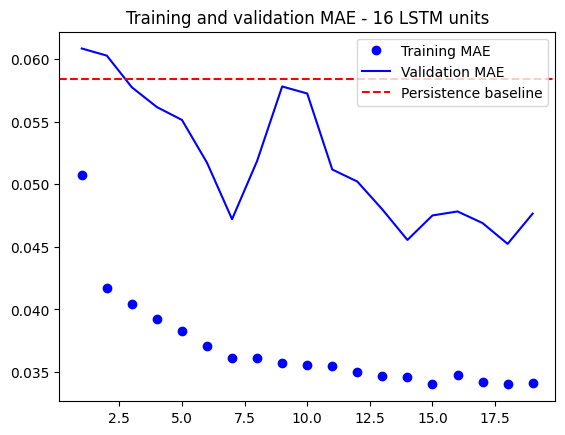

In [9]:
# See if early stopping does any better

inputs = keras.Input(shape=(36, 1))

x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

path_checkpoint = f"model_checkpoint_early_stopping_recurrent_dropout.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    )

history = model.fit(train,
                    epochs=20,
                    validation_data=validation,
                        callbacks=[es_callback, modelckpt_callback],
                    )


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

persistence_mae = 0.0584

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [10]:
model.evaluate(test) # beating baseline!

704/704 [==============================] - 1s 1ms/step - loss: 0.0042 - mae: 0.0479


[0.004218983929604292, 0.04792454093694687]

## Loading results and displaying training runs

In [11]:
with open('dropout_experiments.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

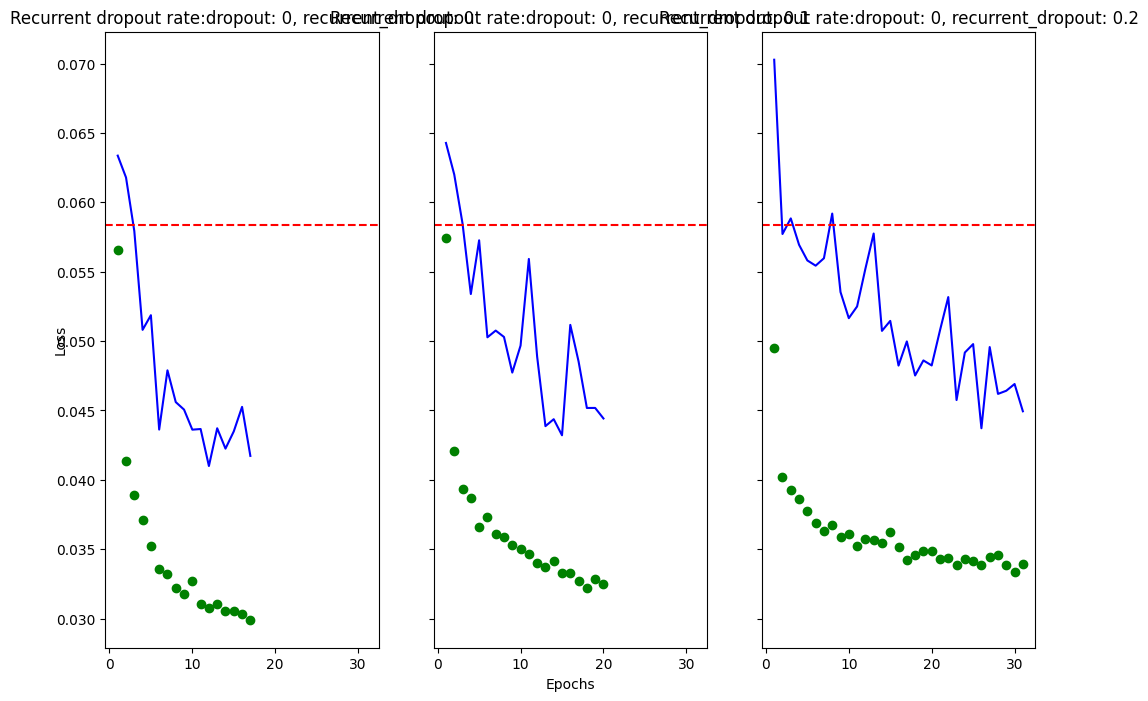

In [12]:
persistence_baseline = persistence_mae


# Create the figure and axes
fig, axes = plt.subplots(figsize=(12,8), nrows=1, ncols=3, sharex=True, sharey=True)

# Loop over the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    key = list(loaded_dict.keys())[i]

    epochs = loaded_dict[key]['epochs']
    loss = loaded_dict[key]['loss']
    val_loss = loaded_dict[key]['val_loss']

    ax.plot(epochs, loss, "go", label="Training MAE")
    ax.plot(epochs, val_loss, "b", label="Validation MAE")
    ax.axhline(y=persistence_baseline, color='r', linestyle='--', label='Persistence baseline')
    ax.set_title(f"Recurrent dropout rate:{key}")
    

# Add a common x-axis label and a common y-axis label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.xlabel("Epochs")
plt.ylabel("Loss")


# Add the legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

fig.suptitle("Training and Validation Loss Across Different Recurrent dropout rates")

# Display the figure
plt.show()
